In [82]:
# Initialize task.
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
import matplotlib.colors as colors
from scipy.stats import norm
from scipy.optimize import minimize
from jax import hessian, random

snb.set_theme(font_scale=1.25)

# Load Data

data = jnp.load('./data_exercise5b.npz')
X = data['day']
y = np.log(data['bike_count'])

#Standardize data
ym, ys = jnp.mean(y), jnp.std(y)
y = (y - ym) / ys

## Part 1: Fully Bayesian inference for Gaussian process regression 

**Task 1.1 Choose a value for $\textit{v}$ such that the prior probability of observing a lengthscale larger than 100 is approximately $1\%$**

First, we identify that our lengthscale parameter follows af half normal distribution 

\begin{equation*}
    \ell \sim \mathcal{N}_+(0,v)
\end{equation*}

We know the condition we need to fulfill is

\begin{equation*}
    P(\ell > 100) \approx 0.01
\end{equation*}

We can express our distribution $\ell = |Z\sqrt{v}|$ with $Z$ being a standard normal variable, since $\ell$ is a half normal. Since the standard normal distribution is symmetric we view it as a two-tailed probability.

\begin{align*}
P(\ell > 100) = P(|Z\sqrt{v}| > 100) &\approx 0.01 \\
P(|Z| > \frac{100}{\sqrt{v}}) &\approx 0.01 \hspace{2cm} (\text{Two-tailed}) \\
2 \cdot P(\frac{Z > 100}{ \sqrt{v}}) &\approx 0.01 \\
P(\frac{Z > 100}{ \sqrt{v}}) &\approx 0.005\\
\Rightarrow v = \left(\frac{100}{z_{0.005}} \right)^2 = 1507.18 &\approx 1507 
\end{align*}


So when $v \approx 1507$ the probability of the lengthscale parameter being above 100 will be roughly 1%

**Task 1.2 Determine the marginalized distribution $p(y,\sigma, k, \ell)$**

The joint distribution is as follows
$$
\begin{align*} p(\boldsymbol{y}, f, \sigma, \kappa, \ell) & =p\left(y \mid \boldsymbol{f}, \sigma^2\right) p(f \mid \kappa, \ell) p(\kappa) p(\ell) p(\sigma) \\ & =\mathcal{N}\left(\boldsymbol{y} \mid \boldsymbol{f}, \sigma^2 \boldsymbol{I}\right) \mathcal{N}(\boldsymbol{f} \mid \mathbf{0}, \boldsymbol{K}) \mathcal{N}_{+}(\kappa \mid 0,1) \mathcal{N}_{+}(\ell \mid 0, v) \mathcal{N}_{+}(\sigma \mid 0,1).
\end{align*}
$$


Denoting $\mathcal{N}_{+}(\kappa \mid 0,1) \mathcal{N}_{+}(\ell \mid 0, v) \mathcal{N}_{+}(\sigma \mid 0,1) = p(\kappa,\ell,\sigma)$ we get the following for marginalising out $f$ from the joint distribution:
$$
\begin{align*}
p(\boldsymbol{y}, \sigma, \kappa, \ell) 
&= 
\int p(\boldsymbol{y}, f, \sigma, \kappa, \ell)\ \text{d}f \\
&= 
p(\kappa,\ell,\sigma)
\underbrace{\int \mathcal{N}\left(\boldsymbol{y} \mid \boldsymbol{f}, \sigma^2 \boldsymbol{I}\right) \mathcal{N}(\boldsymbol{f} \mid \mathbf{0}, \boldsymbol{K})\ \text{d}f}_{\text{Marginal likelihood = linear Gaussian system}} \\
&=
p(\kappa,\ell,\sigma) \mathcal{N}(\boldsymbol{y} \mid \mathbf{0}, \boldsymbol{K} + \sigma^2 \boldsymbol{I})
\end{align*}
$$


**Task 1.3: Implement a Metropolis sampler using the proposal distribution**

In [83]:
def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):
    """
    Runs a Metropolis-Hastings sampler.

    Arguments:
        log_target: function evaluating the log target, expecting a vector (size=num_params)
        num_params: number of parameters
        tau:        vector of proposal standard deviations (one per parameter)
        num_iter:   number of iterations
        theta_init: initial parameter vector (or None)
        seed:       random seed

    Returns:
        thetas:   jnp.array of shape (num_iter+1, num_params)
        accepts:  list of acceptance flags
    """
    key = random.PRNGKey(seed)
    if theta_init is None:
        theta_init = jnp.zeros((num_params))
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_target(theta_init)

    for k in range(num_iter):
        key, key_proposal, key_accept = random.split(key, num=3)
        theta_cur = thetas[-1]
        # Elementwise proposal using tau for each parameter.
        theta_star = theta_cur + tau * random.normal(key_proposal, shape=(num_params,))
        log_p_theta_star = log_target(theta_star)
        log_r = log_p_theta_star - log_p_theta
        A = min(1, jnp.exp(log_r))
        if random.uniform(key_accept) < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)
        thetas.append(theta_next)

    print("Acceptance ratio: %3.2f" % jnp.mean(jnp.array(accepts)))
    thetas = jnp.stack(thetas)
    assert thetas.shape == (
        num_iter + 1,
        num_params,
    ), f"Expected shape {(num_iter+1, num_params)}, got {thetas.shape}."
    return thetas, accepts

In [ ]:
def metropolis_multiple_chains(
    log_target, num_params, num_chains, tau, num_iter, theta_init, seeds, warm_up=0
):
    """Runs multiple Metropolis-Hastings chains. The i'th chain should be initialized using the i'th vector in theta_init, i.e. theta_init[i, :]

    Arguments:
        log_target:         function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        num_chains:         number of MCMC chains
        tau:                proposal standard deviation (jnp.array with shape (num_params,))
        num_iter:           number of iterations for each chain (integer)
        theta_init:         array of initial values (jnp.array with shape (num_chains, num_params))
        seeds:              seed for each chain (jnp.array with shape (num_chains))
        warm_up:            number of warm up samples to be discarded

    returns:
        thetas              jnp.array of samples from each chain after warmup (shape: num_chains x (num_iter + 1 - warm_up))
        accept_rates        jnp.array of acceptances rate for each chain (shapes: num_chains)

    """

    # verify dimension of initial parameters
    assert theta_init.shape == (
        num_chains,
        num_params,
    ), "theta_init seems to have the wrong dimensions. Plaese check your code."
    
    # prepare arrays for storing samples
    thetas = []
    accept_rates = []

    # run sampler for each chain
    for idx_chain in range(num_chains):
        print(f"Running chain {idx_chain}. ", end="")
        thetas_temp, accepts_temp = metropolis(
            log_target,
            num_params,
            tau,
            num_iter,
            theta_init=theta_init[idx_chain],
            seed=seeds[idx_chain],
        )
        thetas.append(thetas_temp)
        accept_rates.append(jnp.array(accepts_temp))

    thetas = jnp.stack(thetas, axis=0)
    accept_rates = jnp.stack(accept_rates, axis=0)

    # discard warm-up samples
    thetas = thetas[:, warm_up:, :]

    # verify dimensions and return
    assert thetas.shape == (
        num_chains,
        num_iter + 1 - warm_up,
        num_params,
    ), f"The expected shape of chains is ({num_chains}, {num_iter+1-warm_up}, {num_params}) corresponding to (num_chains, num_iter+1-warm_up), but the actual shape is {thetas.shape}. Check your implementation."
    assert len(accept_rates) == num_chains
    return thetas, accept_rates

In [ ]:
# Log half-normal prior.
def log_halfnormal(x, scale=1.0):
    return jnp.log(2 / scale) + norm.logpdf(x, 0, scale)


def squared_exponential(tau, kappa, lengthscale):
    return kappa**2 * jnp.exp(-0.5 * tau**2 / (lengthscale**2))


class StationaryIsotropicKernel(object):

    def __init__(self, kernel_fun, kappa=1.0, lengthscale=1.0):
        """
        the argument kernel_fun must be a function of three arguments kernel_fun(||tau||, kappa, lengthscale), e.g.
        squared_exponential = lambda tau, kappa, lengthscale: kappa**2*np.exp(-0.5*tau**2/lengthscale**2)
        """
        self.kernel_fun = kernel_fun
        self.kappa = kappa
        self.lengthscale = lengthscale

    def contruct_kernel(self, X1, X2, kappa=None, lengthscale=None, jitter=1e-8):
        """compute and returns the NxM kernel matrix between the two sets of input X1 (shape NxD) and X2 (MxD) using the stationary and isotropic covariance function specified by self.kernel_fun

        arguments:
            X1              -- NxD matrix
            X2              -- MxD matrix
            kappa           -- magnitude (positive scalar)
            lengthscale     -- characteristic lengthscale (positive scalar)
            jitter          -- non-negative scalar

        returns
            K               -- NxM matrix
        """

        # extract dimensions
        N, M = X1.shape[0], X2.shape[0]

        # prep hyperparameters
        kappa = self.kappa if kappa is None else kappa
        lengthscale = self.lengthscale if lengthscale is None else lengthscale

        # compute all the pairwise distances efficiently
        dists = jnp.sqrt(
            jnp.sum((jnp.expand_dims(X1, 1) - jnp.expand_dims(X2, 0)) ** 2, axis=-1)
        )

        # squared exponential covariance function
        K = self.kernel_fun(dists, kappa, lengthscale)

        # add jitter to diagonal for numerical stability
        if len(X1) == len(X2) and jnp.allclose(X1, X2):
            K = K + jitter * jnp.identity(len(X1))


        assert K.shape == (
            N,
            M,
        ), f"The shape of K appears wrong. Expected shape ({N}, {M}), but the actual shape was {K.shape}. Please check your code. "
        return K


# Log joint function: returns -inf if any parameter ≤ 0.
def log_marginal_likelihood(theta, X, y, v=1507.0):
    kappa, ell, sigma = theta
    n = y.shape[0]
    if (kappa <= 0) or (ell <= 0) or (sigma <= 0):
        return -jnp.inf
    # Priors.
    lp_kappa = log_halfnormal(kappa, scale=1.0)
    lp_ell = log_halfnormal(ell, scale=jnp.sqrt(v))
    lp_sigma = log_halfnormal(sigma, scale=1.0)
    log_prior = lp_kappa + lp_ell + lp_sigma

    # Kernel matrix computation.
    kernel = StationaryIsotropicKernel(squared_exponential, kappa, ell)
    K = kernel.contruct_kernel(X, X)
    C = K + sigma**2 * jnp.eye(n)

    # Compute the Cholesky decomposition.
    L = jnp.linalg.cholesky(C)
    v_vec = jnp.linalg.solve(L, y)

    # Compute log marginal likelihood.
    logdet_term = jnp.sum(jnp.log(jnp.diag(L)))
    quad_term   = 0.5 * jnp.sum(v_vec**2)
    const_term  = -0.5 * n * jnp.log(2 * jnp.pi)
    log_likelihood = const_term - logdet_term - quad_term

    return log_prior + log_likelihood

def log_target(theta):
    """Log target function for the Metropolis-Hastings sampler.

    Arguments:
        theta:             jnp.array of parameters (jnp.array with shape (num_params))

    Returns:
        log_target:        log target distribution (real number)
    """
    # Compute the log target distribution.
    log_mar_likelihood = log_marginal_likelihood(theta, X, y)
    log_target = log_mar_likelihood
    return log_target

In [98]:
# mcmc settings
num_chains = 4
num_iter = 10000
tau = jnp.array([1.0, 100.0, 0.1])
num_params = 3

warm_up = 0
seeds = jnp.arange(num_chains)

# generate initial values from uniform distribution
key = random.PRNGKey(1)
theta_init = random.uniform(
    key, shape=(num_chains, num_params), minval=0.1, maxval=2.0
)

# sample
chains, accepts = metropolis_multiple_chains(
    log_target,
    num_params,
    num_chains,
    tau,
    num_iter,
    theta_init=theta_init,
    seeds=seeds,
    warm_up=warm_up,
)
# report estimated mean and variance
print(f"\nEstimated mean:\t\t{jnp.mean(chains.ravel()):+3.2f}")
print(f"Estimated variance:\t{jnp.var(chains.ravel()):+3.2f}")

Running chain 0. Acceptance ratio: 0.02
Running chain 1. Acceptance ratio: 0.02
Running chain 2. Acceptance ratio: 0.02
Running chain 3. Acceptance ratio: 0.02

Estimated mean:		+18.20
Estimated variance:	+644.37


**Task 1.4: Plot the trace for each parameter and report the convergence diagnostics**

Number of warm-up samples discarded: 4000

Parameter 1:
  Effective sample size:  304
  ˆR:                     1.00

Parameter 2:
  Effective sample size:  414
  ˆR:                     1.00

Parameter 3:
  Effective sample size:  440
  ˆR:                     1.00


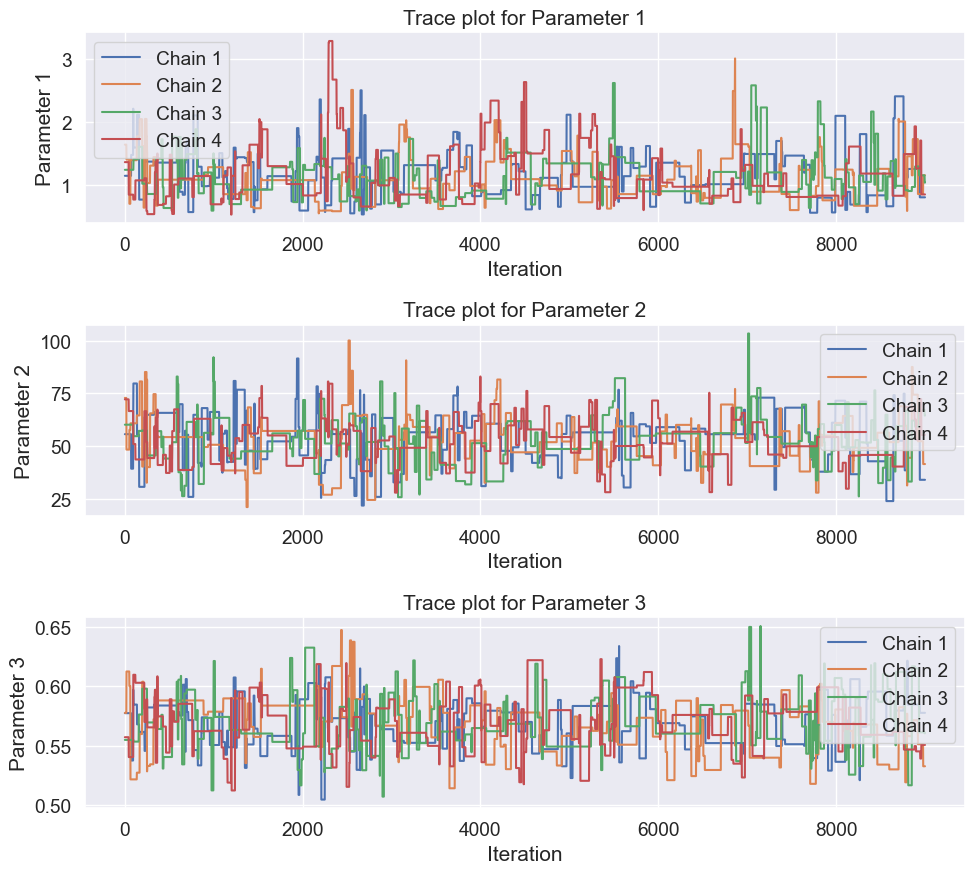

In [108]:
def compute_Rhat(chains):
    """
    Compute the Gelman-Rubin Rhat diagnostic for each parameter.
    Expects chains to be a jnp.array of shape (num_chains, num_samples, num_params).
    Returns a jnp.array of shape (num_params,).
    """
    num_chains, num_samples, num_params = chains.shape
    chain_means = jnp.mean(chains, axis=1)  # shape: (num_chains, num_params)
    overall_mean = jnp.mean(chains, axis=(0, 1))  # shape: (num_params,)
    B = (
        num_samples
        / (num_chains - 1)
        * jnp.sum((chain_means - overall_mean) ** 2, axis=0)
    )  # between-chain variance.
    # Use ddof=1 for unbiased sample variance
    W = jnp.mean(jnp.var(chains, axis=1, ddof=1), axis=0)  # within-chain variance.
    var_plus = ((num_samples - 1) / num_samples) * W + (1 / num_samples) * B
    Rhat = jnp.sqrt(var_plus / W)
    return Rhat


def compute_effective_sample_size(chains):
    """
    Compute a basic effective sample size (S_eff) approximation for each parameter.
    This implementation uses the lag autocorrelations of the merged chains.
    Returns a jnp.array of shape (num_params,).
    """
    num_chains, num_samples, num_params = chains.shape
    total_samples = int(num_chains * num_samples)
    S_eff = jnp.zeros(num_params)
    chains_np = np.array(chains)  # switch to numpy for autocorrelation computations

    for p in range(num_params):
        # merge chains for parameter p
        x = chains_np[:, :, p].reshape(-1)
        # compute autocorrelation for increasing lag until the correlation becomes negative
        ac_sum = 0.0
        for lag in range(1, num_samples):
            # compute autocorrelation at lag 'lag'
            corr = np.corrcoef(x[:-lag], x[lag:])[0, 1]
            if corr < 0:
                break
            ac_sum += corr
        S_eff = S_eff.at[p].set(total_samples / (1 + 2 * ac_sum))
    return S_eff

warm_up = 1000
# Compute number of warm-up samples discarded (per chain)
total_warm_up = num_chains * warm_up
print(f"Number of warm-up samples discarded: {total_warm_up}")

# Compute estimated overall mean and variance, pooling all samples
all_samples = chains.reshape(-1, chains.shape[-1])  # shape: (total_samples, num_params)

# Compute convergence diagnostics.
Rhat = compute_Rhat(chains)
total_samples = num_chains * (chains.shape[1])  # after warm-up
S_eff = compute_effective_sample_size(chains)

# Print results
for p in range(all_samples.shape[1]):
    print(f"\nParameter {p+1}:")
    print(f"  Effective sample size:  {S_eff[p]:.0f}")
    print(f"  ˆR:                     {Rhat[p]:3.2f}")

# Plot trace for each parameter.
num_params = chains.shape[-1]
fig, axes = plt.subplots(num_params, 1, figsize=(10, 3 * num_params))
if num_params == 1:
    axes = [axes]  # ensure axes is iterable

for p in range(num_params):
    for chain in range(chains.shape[0]):
        axes[p].plot(chains[chain, warm_up:, p], label=f"Chain {chain+1}")
    axes[p].set_xlabel("Iteration")
    axes[p].set_ylabel(f"Parameter {p+1}")
    axes[p].set_title(f"Trace plot for Parameter {p+1}")
    axes[p].legend()

plt.tight_layout()
plt.show()

**Task 1.5: Estimate and report the posterior mean for each hyperparameter. Report the MCSE
for each estimate.**

In [109]:
# Compute estimated overall mean and variance, pooling all samples
all_samples = chains.reshape(-1, chains.shape[-1])  # shape: (total_samples, num_params)
estimated_mean = jnp.mean(all_samples, axis=0)
estimated_var = jnp.var(all_samples, axis=0)  
estimated_std = jnp.sqrt(estimated_var)
MC_error = estimated_std / jnp.sqrt(S_eff)

for p in range(all_samples.shape[1]):
    print(f"\nParameter {p+1}:")
    print(f"  Estimated mean:         {estimated_mean[p]:+3.2f}")
    print(f"  MCSE:                   {MC_error[p]:+3.2f}")


Parameter 1:
  Estimated mean:         +1.15
  MCSE:                   +0.02

Parameter 2:
  Estimated mean:         +52.89
  MCSE:                   +0.56

Parameter 3:
  Estimated mean:         +0.57
  MCSE:                   +0.00


**Task 1.6: Estimate a 95% posterior credibility interval for each hyperparameter.**

In [ ]:
# Compute 95% credibility intervals for each hyperparameter.
cred_intervals = np.percentile(np.array(all_samples), [2.5, 97.5], axis=0)

for p in range(cred_intervals.shape[1]):
    print(
        f"Parameter {p+1} 95% Credibility Interval: [{cred_intervals[0, p]:.2f}, {cred_intervals[1, p]:.2f}]"
    )

Parameter 1 95% Credibility Interval: [0.60, 2.11]
Parameter 2 95% Credibility Interval: [30.05, 74.45]
Parameter 3 95% Credibility Interval: [0.53, 0.61]
